<a href="https://colab.research.google.com/github/kevinmcmanus/cas-tau/blob/master/AstropyTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery

     |████████████████████████████████| 6.5MB 6.4MB/s 
     |████████████████████████████████| 2.7MB 54.7MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=895823947e91bbe632d059a8453086772847bdfe26cc986f96ca871f14868277
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.colors as colors
%matplotlib inline

In [3]:
from astropy.coordinates import Angle
import astropy.units as u
from astroquery.simbad import Simbad
import astropy.coordinates as coord
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.table import QTable, Table, vstack
from astropy.units import Quantity

```
Byte-by-byte Description of file: nhi_hpx.dat
--------------------------------------------------------------------------------
   Bytes Format  Units   Label     Explanations
--------------------------------------------------------------------------------
   1-  8  I8     ---     HPX       HPX index (HPXINDEX)
  10- 18  F9.5   deg     RAdeg     Right ascension (J2000)
  20- 28  F9.5   deg     DEdeg     Declination (J2000)
  30- 38  F9.5   deg     GLON      Galactic longitude (J2000)
  40- 48  F9.5   deg     GLAT      Galactic latitude (J2000)
  50- 71  E22.15 cm-2    NHI       HI column density
--------------------------------------------------------------------------------
```

In [4]:

url = 'https://cdsarc.unistra.fr/ftp/J/A+A/594/A116/nhi_hpx.dat.gz'
cols = ['HPX', 'RAdeg','DEdeg','GLON','GLAT', 'NHI']

hi4pi = pd.read_csv(url, delim_whitespace=True, names=cols, header=None)

In [5]:
hi4pi.head()

,HPX,RAdeg,DEdeg,GLON,GLAT,NHI
0,0,192.90971,27.13788,45.0,89.95431,9.174280e+19
1,1,192.84877,27.17301,135.0,89.95431,9.244184e+19
2,2,192.80931,27.11878,225.0,89.95431,9.394214e+19
3,3,192.87024,27.08366,315.0,89.95431,9.281170e+19
4,4,192.96046,27.11176,22.5,89.90863,9.085496e+19


In [6]:
#don't run this code -- takes 20 minutes
#fig = plt.figure(figsize=(12,12))
#ax = fig.add_subplot(111)
#ax.scatter(hi4pi.RAdeg, hi4pi.DEdeg, c=hi4pi.NHI, cmap='gnuplot')
#ax.invert_xaxis()

In [7]:
#round to 1/10 degree precision
hi4pi['RAdeg1'] = np.round(hi4pi.RAdeg,1)
hi4pi['DEdeg1'] = np.round(hi4pi.DEdeg, 1)
hi4pi['GLAT1'] = np.round(hi4pi.GLAT,1)
hi4pi['GLON1'] = np.round(hi4pi.GLON,1)

In [8]:
#equatorial coords
hi4pi_eq = hi4pi[['RAdeg1', 'DEdeg1', 'NHI']].groupby(['RAdeg1','DEdeg1']).mean().reset_index()
hi4pi_eq.rename(columns={"RAdeg1":"ra", "DEdeg1":"dec"}, inplace=True)

#galactic coords
hi4pi_gal = hi4pi[['GLON1', 'GLAT1', 'NHI']].groupby(['GLON1','GLAT1']).mean().reset_index()
hi4pi_gal.rename(columns={"GLON1":"l", "GLAT1":"b"}, inplace=True)

In [9]:
#convert everybody to angles and wrap the longitude
hi4pi_eq.ra = Angle(np.array(hi4pi_eq.ra)*u.degree).wrap_at(180*u.degree)
hi4pi_eq.dec = Angle(np.array(hi4pi_eq.dec)*u.degree)

hi4pi_gal.l = Angle(np.array(hi4pi_gal.l)*u.degree).wrap_at(180*u.degree)
hi4pi_gal.b = Angle(np.array(hi4pi_gal.b)*u.degree)

In [10]:
#create the image arrays
#note declination and lattitude in 'x' (row) positions and ra and longitude in 'y' (column) positions
image_eq = pd.pivot_table(hi4pi_eq,index='dec',columns='ra', values='NHI',aggfunc=np.mean).to_numpy( copy=True)

image_gal = pd.pivot_table(hi4pi_gal,index='b',columns='l', values='NHI',aggfunc=np.mean).to_numpy( copy=True)
image_eq.shape, image_gal.shape

((1801, 3600), (1801, 3600))

In [11]:
ra_vec = Angle(np.linspace(hi4pi_eq.ra.min(), hi4pi_eq.ra.max(), image_eq.shape[1], endpoint=False)*u.degree)
dec_vec= Angle(np.linspace(hi4pi_eq.dec.min(), hi4pi_eq.dec.max(), image_eq.shape[0], endpoint=False)*u.degree)

l_vec = Angle(np.linspace(hi4pi_gal.l.min(), hi4pi_gal.l.max(), image_gal.shape[1], endpoint=False)*u.degree)
b_vec = Angle(np.linspace(hi4pi_gal.b.min(), hi4pi_gal.b.max(), image_gal.shape[0], endpoint=False)*u.degree)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


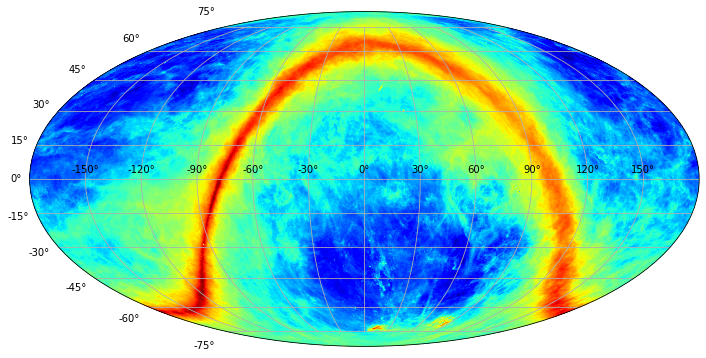

In [12]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='mollweide')
ax.pcolormesh(ra_vec.radian,
           dec_vec.radian,
           image_eq,
           cmap='jet', norm=colors.LogNorm())
ax.grid()

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


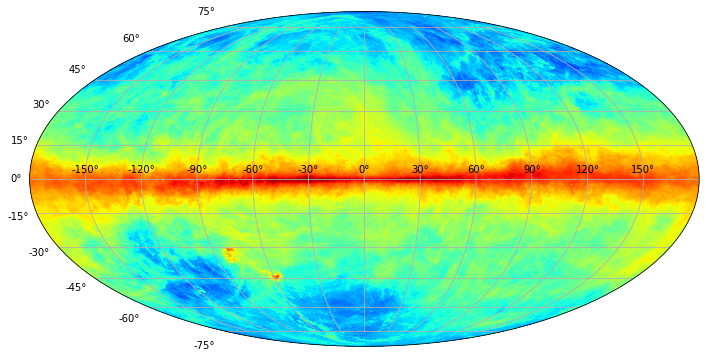

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='jet', norm=colors.LogNorm())
ax.grid()

In [14]:
clusters = ['Blanco 1',
 'Collinder 140',
 'Coma Berenices Cluster',
 'Hyades',
 'Pleiades',
 'Praesepe',
 'alpha Per']

In [15]:
# set up the Simbad query
from astroquery.simbad import Simbad
from astropy.time import Time
mySimbad = Simbad()
mySimbad.add_votable_fields('parallax', 'pm','velocity','typed_id')
mySimbad.get_votable_fields()


['main_id', 'coordinates', 'parallax', 'pm', 'velocity', 'typed_id']

In [16]:
#from astropy.table import Table, vstack
res_table = vstack([mySimbad.query_object(c) for c in clusters],join_type='exact')

In [17]:
def fix_table(res_table):
  cluster_info=Table(res_table['TYPED_ID', 'PLX_VALUE', 'PLX_PREC','RA', 'RA_PREC', 'DEC', 'DEC_PREC',
                              'PMRA', 'PMDEC', 'RVZ_RADVEL', 'RVZ_ERROR'])

  #gotta be a better way to do this:
  cluster_info['TYPED_ID'] = [c.decode('utf-8') for c in cluster_info['TYPED_ID']]

  #rename the columns to look like Gaia
  cluster_info.rename_column('TYPED_ID','cluster')
  cluster_info.rename_column('PLX_VALUE','parallax')
  cluster_info.rename_column('PLX_PREC', 'parallax_error')
  cluster_info.rename_column('RA', 'ra')
  cluster_info.rename_column('RA_PREC','ra_error')
  cluster_info.rename_column('DEC', 'dec')
  cluster_info.rename_column('DEC_PREC','dec_error')
  cluster_info.rename_column('PMRA', 'pmra')
  cluster_info.rename_column('PMDEC', 'pmdec')
  cluster_info.rename_column('RVZ_RADVEL','radial_velocity')
  cluster_info.rename_column('RVZ_ERROR', 'rv_error')

  #unmask the columns
  cluster_info = cluster_info.filled() 


  #index on the cluster name
  cluster_info.add_index('cluster')

  # coordinates,  note the update to J2015.5 to match with Gaia
  cluster_info['coords'] = \
      SkyCoord(ra = cluster_info['ra'],
          dec = cluster_info['dec'], unit = (u.hour, u.deg),
          obstime = 'J2000',  #simbad returns J2000 coords
          distance = coord.Distance(parallax=Quantity(cluster_info['parallax'])),
          pm_ra_cosdec = cluster_info['pmra'],
          pm_dec = cluster_info['pmdec'],
          radial_velocity = cluster_info['radial_velocity']).apply_space_motion(new_obstime=Time('2015.5',format='decimalyear'))

  return cluster_info

In [18]:
open_cluster_info=fix_table(res_table)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


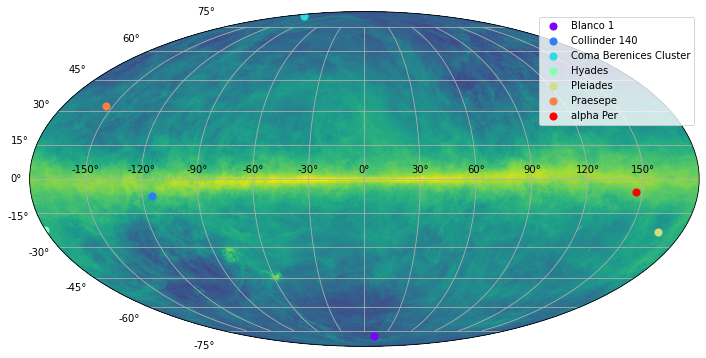

In [19]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='viridis', norm=colors.LogNorm())

# plot the clusters
color=iter(plt.cm.rainbow(np.linspace(0,1,len(clusters))))
for c in clusters:
  ax.scatter(open_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, open_cluster_info.loc[c]['coords'].galactic.b.radian, 
    color=next(color), s=50, label=c)
ax.grid()
ax.legend(loc='upper right')

In [20]:
glob_clusters=['NGC0104', 'NGC0288', 'NGC0362', 'NGC1851', 'NGC5272', 'NGC5904',
       'NGC6205', 'NGC6218', 'NGC6341', 'NGC6397', 'NGC6656', 'NGC6752',
       'NGC6809', 'NGC7099']

In [21]:
#from astropy.table import Table, vstack
res_table = vstack([mySimbad.query_object(c) for c in glob_clusters],join_type='exact')

In [22]:
glob_cluster_info = fix_table(res_table)

In [24]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0, 0.5, 'log(NHI)')

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


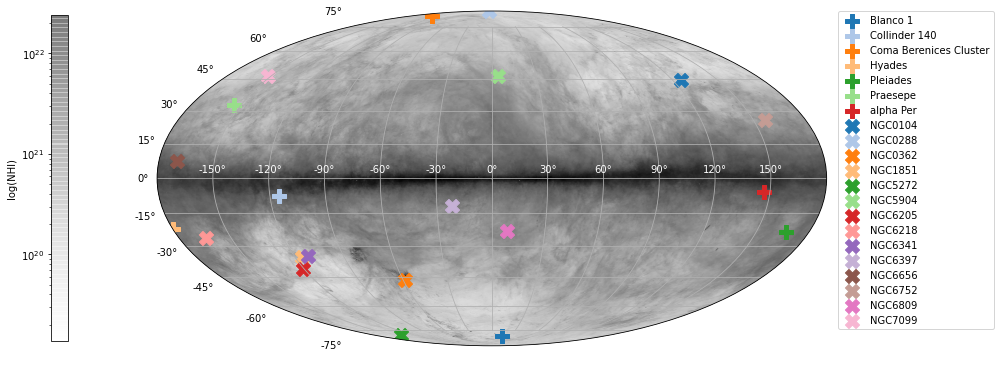

In [46]:
fig = plt.figure(figsize=(16,12))

#gs1 = gridspec.GridSpec(1, 2, width_ratios=(1,9))

#main plot axis
#ax = plt.subplot(gs1[0,1], projection='mollweide')
ax = fig.add_subplot(111, projection='mollweide')
pcm = ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='Greys', norm=colors.LogNorm(),alpha=0.3)

# plot the clusters
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in clusters:
  ax.scatter(open_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, open_cluster_info.loc[c]['coords'].galactic.b.radian, 
    marker='P',color=next(color), s=200, label=c, alpha=1.0)
  
# plot the globs
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in glob_clusters:
  ax.scatter(glob_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, glob_cluster_info.loc[c]['coords'].galactic.b.radian, 
    marker='X',color=next(color), s=200, label=c, alpha=1.0)
ax.grid()
ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0.05)
#ax.legend(loc='upper right')
#ax.invert_xaxis()
ax.tick_params(axis='x', colors='white')
ax.set_xlabel('Galactic Longitude', color='White')
ax.set_ylabel('Galactic Latitude', color='white')
#put the colorbar to the left
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("left", size="5%", pad=0.05)
#cax = plt.subplot(gs1[0,0])
cb = plt.colorbar(pcm, ax=[ax], location="left", shrink=0.5)
cb.ax.set_ylabel('log(NHI)')


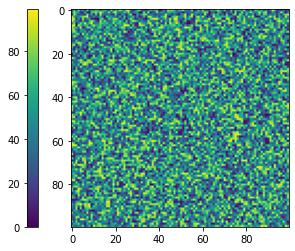

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(np.random.randint(0, 100, (100, 100)))
cb = plt.colorbar(axp,ax=[ax],location='left')
plt.show()

In [ ]:
 = ax.imshow(np.arange(100).reshape((10,10)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


Text(0, 0.5, 'log(NHI)')

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


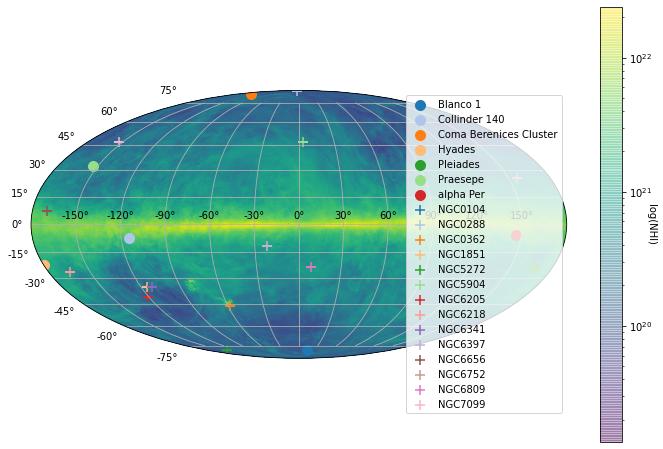

In [ ]:
fig = plt.figure(figsize=(12,8))

#axis for main plot
ax = fig.add_subplot(111, projection='mollweide')
pcm = ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='viridis', norm=colors.LogNorm(),alpha=0.3)

# plot the clusters
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in clusters:
  ax.scatter(open_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, open_cluster_info.loc[c]['coords'].galactic.b.radian, 
    color=next(color), s=100, label=c)
  
# plot the globs
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in glob_clusters:
  ax.scatter(glob_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, glob_cluster_info.loc[c]['coords'].galactic.b.radian, 
    marker='+',color=next(color), s=100, label=c)
ax.grid()
ax.legend(loc='upper right')

cb = fig.colorbar(pcm, ax=ax)
cb.ax.set_ylabel('log(NHI)',rotation=270)
#ax.invert_xaxis()

In [ ]:
# reduce resolution to 3600 x 1800
rastep = 0.1 # tenth degree steps
decstep = 0.1 # tenth degree steps


In [ ]:
hi4pi['RAint'] = (hi4pi.RAdeg//rastep).astype(int)
hi4pi['DEint'] = ((90+hi4pi.DEdeg)//decstep).astype(int)


In [ ]:
hi4pi.head()

,HPX,RAdeg,DEdeg,GLON,GLAT,NHI,RAint,DEint
0,0,192.90971,27.13788,45.0,89.95431,9.174280e+19,1929,1171
1,1,192.84877,27.17301,135.0,89.95431,9.244184e+19,1928,1171
2,2,192.80931,27.11878,225.0,89.95431,9.394214e+19,1928,1171
3,3,192.87024,27.08366,315.0,89.95431,9.281170e+19,1928,1170
4,4,192.96046,27.11176,22.5,89.90863,9.085496e+19,1929,1171


In [ ]:
hi4pi_01 = hi4pi[['RAint','DEint','NHI']].groupby(['DEint','RAint']).mean().reset_index()
hi4pi_image = pd.pivot_table(hi4pi_01,index='DEint',columns='RAint', values='NHI',aggfunc=np.mean).to_numpy( copy=True)

In [ ]:
ra_vec = np.linspace(0,360, 3600,  endpoint=False)
dec_vec= np.linspace(-90,90,1800, endpoint=False)

In [ ]:
decdec, rara = np.meshgrid(dec_vec, ra_vec)

In [ ]:
decdec.shape

(3600, 1800)

In [ ]:
xx=np.arange(10)

In [ ]:
xx[:len(xx)-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


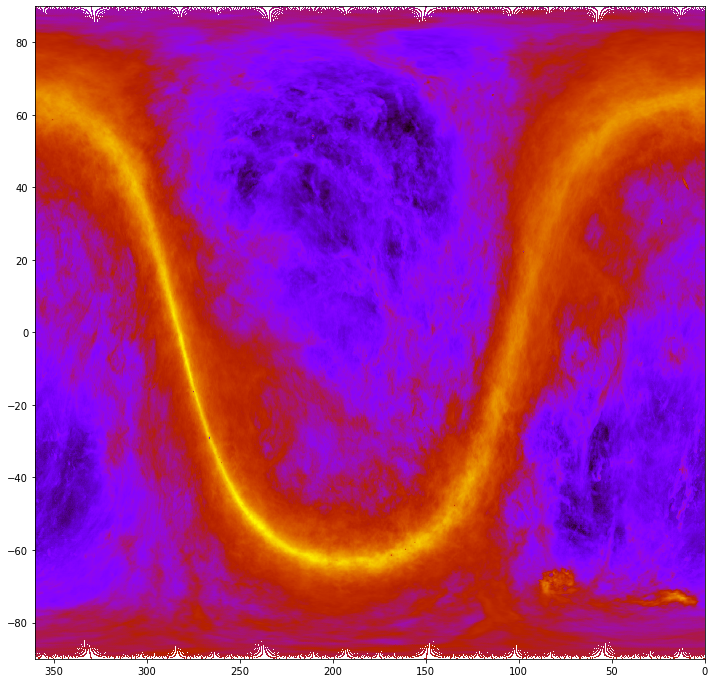

In [ ]:

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.pcolormesh(ra_vec,dec_vec, hi4pi_image, cmap='gnuplot', norm=colors.LogNorm())
ax.invert_xaxis()

In [ ]:
from astropy.coordinates import Angle
import astropy.units as u

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


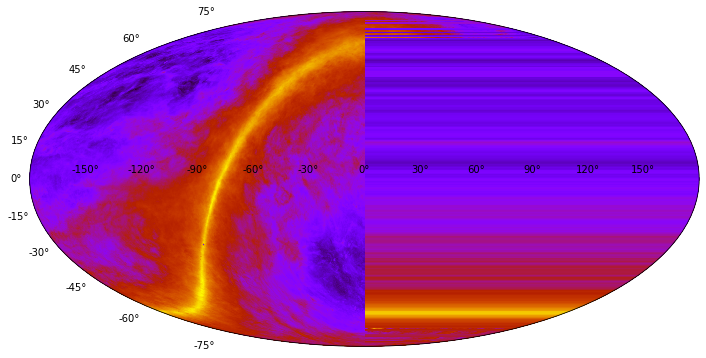

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='mollweide')
#ax.pcolormesh(Angle(ra_vec*u.degree).wrap_at(180*u.degree).radian,
#              Angle(dec_vec*u.degree).radian,
#              hi4pi_image, cmap='gnuplot', norm=colors.LogNorm())
ax.scatter(hi4pi1.RAdeg1, hi4pi1.DEdeg1, c=hi4pi1.NHI, cmap='gnuplot', norm=colors.LogNorm())

#ax.invert_xaxis()

In [ ]:
Angle(90*u.degree).wrap_at('180d').radian

1.5707963267948966

In [ ]:
hi4pi1.head()

,RAdeg1,DEdeg1,NHI
0,0.0,-88.5,8.180530e+20
1,0.0,-87.3,8.229257e+20
2,0.0,-84.9,7.213047e+20
3,0.0,-84.2,7.731364e+20
4,0.0,-83.4,7.742778e+20


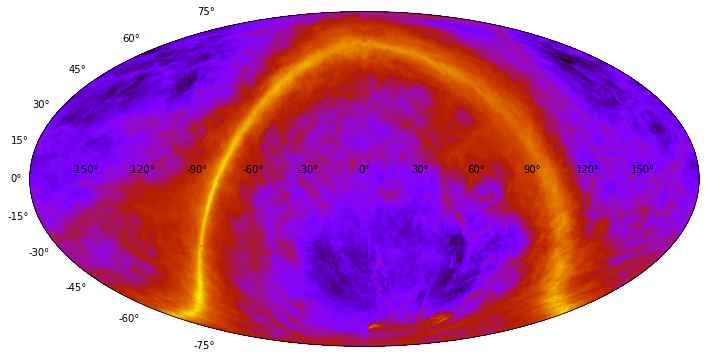

In [ ]:
#this takes a while too!
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(Angle(np.array(hi4pi1.RAdeg1)*u.degree).wrap_at(180*u.degree).radian,
           Angle(np.array(hi4pi1.DEdeg1)*u.degree).radian,
           c=hi4pi1.NHI, cmap='gnuplot', norm=colors.LogNorm())
#ax.invert_xaxis()

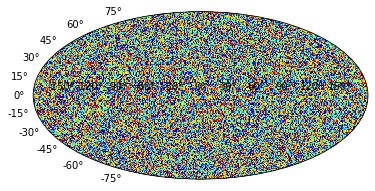

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
arr = np.random.rand(180, 360)

lon = np.linspace(-np.pi, np.pi,360)
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)

im = ax.pcolormesh(Lon,Lat,arr, cmap=plt.cm.jet)

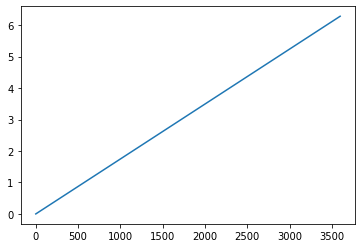

In [ ]:
plt.plot(Angle(ra_vec*u.degree).radian)